
# 🚀 NSL‑KDD Intrusion Detection — Google Colab Notebook

This notebook demonstrates a **simple cybersecurity ML pipeline** on the **NSL‑KDD** public dataset (a cleaned successor to KDD’99).  
We build a classifier that predicts whether a network connection **is malicious or normal**.

**What you'll see:**
- Download + load **NSL‑KDD** (`KDDTrain+.txt`, `KDDTest+.txt`)
- Preprocess categorical & numeric features (one‑hot + scaling)
- Train a model (Logistic Regression; Random Forest optional)
- Evaluate: accuracy, precision, recall, F1, ROC‑AUC
- Plot: confusion matrix and ROC curve

> Dataset source (public mirror): `https://github.com/defcom17/NSL_KDD`  
> Task: **Binary classification** (attack vs normal). You can easily extend to **multiclass** by using the specific attack labels.


In [1]:

#@title Setup
import os, io, sys, math, zipfile, urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
)

print("Versions:")
print("Python:", sys.version.split()[0])
import sklearn, pandas, numpy
print("scikit-learn:", sklearn.__version__)
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)


Versions:
Python: 3.12.12
scikit-learn: 1.6.1
pandas: 2.2.2
numpy: 2.0.2


In [2]:

#@title Download NSL-KDD (train/test) from a public GitHub mirror

BASE = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/"
TRAIN_URL = BASE + "KDDTrain+.txt"
TEST_URL  = BASE + "KDDTest+.txt"

train_path = "KDDTrain+.txt"
test_path  = "KDDTest+.txt"

def fetch(url, path):
    if not os.path.exists(path):
        print(f"Downloading {path} ...")
        urllib.request.urlretrieve(url, path)
    else:
        print(f"Found {path}, skipping download.")

fetch(TRAIN_URL, train_path)
fetch(TEST_URL, test_path)

print("Files ready:", os.path.getsize(train_path), "bytes train,", os.path.getsize(test_path), "bytes test")


Files ready: 19109424 bytes train, 3441513 bytes test


In [3]:

#@title Load data and basic preprocessing

# NSL-KDD has 41 features + 1 label + 1 difficulty column
cols = [
 'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
 'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
 'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
 'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
 'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
 'dst_host_rerror_rate','dst_host_srv_rerror_rate','label','difficulty'
]

def load_nsl_kdd(path):
    df = pd.read_csv(path, names=cols)
    return df

train_df = load_nsl_kdd("KDDTrain+.txt")
test_df  = load_nsl_kdd("KDDTest+.txt")

print(train_df.shape, test_df.shape)
train_df.head(3)


(125973, 43) (22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,neptune,19


In [4]:

#@title Map labels to binary: 1 = attack, 0 = normal
def map_binary_label(s):
    return 0 if s.strip() == 'normal' else 1

for df in (train_df, test_df):
    df['target'] = df['label'].apply(map_binary_label)

y_train = train_df['target'].values
y_test  = test_df['target'].values

X_train = train_df.drop(columns=['label','difficulty','target'])
X_test  = test_df.drop(columns=['label','difficulty','target'])

# Identify categorical and numeric columns
cat_cols = ['protocol_type','service','flag']
num_cols = [c for c in X_train.columns if c not in cat_cols]

len(cat_cols), len(num_cols), X_train.shape


(3, 38, (125973, 41))

In [5]:

#@title Build preprocessing + model pipeline

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(with_mean=False), num_cols),
    ]
)

# Choose model here:
use_random_forest = False  #@param {type:"boolean"}

if use_random_forest:
    model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
else:
    model = LogisticRegression(max_iter=200, n_jobs=None, solver="lbfgs")

pipe = Pipeline([("prep", preprocess), ("clf", model)])

pipe


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type', 'service',
                                                   'flag']),
                                                 ('num',
                                                  StandardScaler(with_mean=False),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes', 'land',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'logged_in',
                                                   'num_compromised',
                                                   'root_shell', 'su_attempted',
                                                   'num_root',
                                                   'num_file_creations',
                                                   'num_shells',
                                                   'num_access_files',
                                                   'num_outbound_cmds',
                                                   'is_host_login',
                                                   'is_guest_login', 'count',
                                                   'srv_count', 'serror_rate',
                                                   'srv_serror_rate',
                                                   'rerror_rate',
                                                   'srv_rerror_rate',
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count', ...])])),
                ('clf', LogisticRegression(max_iter=200))])

In [6]:

#@title Train the model
pipe.fit(X_train, y_train)

train_pred = pipe.predict(X_train)
test_pred  = pipe.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc  = accuracy_score(y_test,  test_pred)

print(f"Train acc: {train_acc:.4f}")
print(f"Test  acc: {test_acc:.4f}")
print()
print("Classification report (test):")
print(classification_report(y_test, test_pred, digits=4))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train acc: 0.9733
Test  acc: 0.7532

Classification report (test):
              precision    recall  f1-score   support

           0     0.6499    0.9259    0.7637      9711
           1     0.9173    0.6225    0.7417     12833

    accuracy                         0.7532     22544
   macro avg     0.7836    0.7742    0.7527     22544
weighted avg     0.8021    0.7532    0.7512     22544



Test ROC-AUC: 0.7928


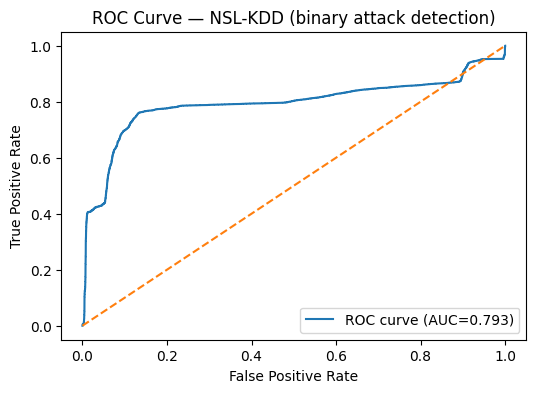

In [7]:

#@title ROC-AUC (test) + curve (matplotlib only)
# Probability estimates for positive class
if hasattr(pipe.named_steps["clf"], "predict_proba"):
    test_proba = pipe.predict_proba(X_test)[:,1]
else:
    # Some models (e.g., SVM without probability) don't have predict_proba
    # fall back to decision_function if available
    if hasattr(pipe.named_steps["clf"], "decision_function"):
        raw = pipe.decision_function(X_test)
        # Min-max to [0,1] for plotting; not true probabilities
        raw_min, raw_max = raw.min(), raw.max()
        test_proba = (raw - raw_min) / (raw_max - raw_min + 1e-12)
    else:
        test_proba = test_pred.astype(float)

auc = roc_auc_score(y_test, test_proba)
print(f"Test ROC-AUC: {auc:.4f}")

fpr, tpr, thr = roc_curve(y_test, test_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — NSL-KDD (binary attack detection)")
plt.legend(loc="lower right")
plt.show()


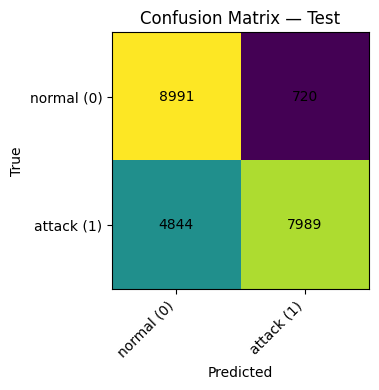

(array([[8991,  720],
        [4844, 7989]]),
 array(['normal (0)', 'attack (1)'], dtype='<U10'))

In [8]:

#@title Confusion Matrix (test)
cm = confusion_matrix(y_test, test_pred)
classes = np.array(["normal (0)","attack (1)"])

plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix — Test")
plt.xticks([0,1], classes, rotation=45, ha="right")
plt.yticks([0,1], classes)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

cm, classes


In [9]:

#@title Quick sanity check: predict on a few random rows from test set
sample_idx = np.random.choice(len(X_test), size=5, replace=False)
sample = X_test.iloc[sample_idx]
preds = pipe.predict(sample)

display(pd.DataFrame({"predicted_attack": preds, "true": y_test[sample_idx]}).reset_index(drop=True))


,predicted_attack,true
0,0,0
1,1,1
2,0,0
3,1,1
4,1,1



## 🧩 Optional: Multiclass (attack type)

For a multiclass task, simply **use the original `label`** field (with values like `normal`, `neptune`, `smurf`, etc.) as the target instead of the binary mapping.  
You can then train the exact same pipeline and examine per‑class metrics.



# 🧪 Examples: Attacks vs Normal & Misclassifications

The next cells surface concrete rows from the **test set** to see what input data looks like — both **correctly detected** and **mistakes** (FP/FN).


In [10]:

#@title Build helper to collect TP/TN/FP/FN examples
import numpy as np
import pandas as pd

def collect_examples(X, y_true, y_pred, proba=None, max_rows=5):
    idx_all = np.arange(len(y_true))
    is_pos = y_true == 1
    is_neg = ~is_pos

    tp_idx = idx_all[(y_pred == 1) & is_pos]
    tn_idx = idx_all[(y_pred == 0) & is_neg]
    fp_idx = idx_all[(y_pred == 1) & is_neg]
    fn_idx = idx_all[(y_pred == 0) & is_pos]

    def build_df(indices):
        take = indices[:max_rows]
        out = X.iloc[take].copy()
        out.insert(0, "y_true", y_true[take])
        out.insert(1, "y_pred", y_pred[take])
        if proba is not None:
            out.insert(2, "p(attack)", proba[take])
        return out.reset_index(drop=True)

    return {
        "TP (attack correctly detected)": build_df(tp_idx),
        "TN (normal correctly detected)": build_df(tn_idx),
        "FP (normal flagged as attack)": build_df(fp_idx),
        "FN (missed attack)": build_df(fn_idx),
    }

# Ensure probabilities exist
if 'test_proba' not in globals():
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        test_proba = pipe.predict_proba(X_test)[:,1]
    elif hasattr(pipe.named_steps["clf"], "decision_function"):
        raw = pipe.decision_function(X_test)
        raw_min, raw_max = raw.min(), raw.max()
        test_proba = (raw - raw_min) / (raw_max - raw_min + 1e-12)
    else:
        test_proba = test_pred.astype(float)

examples = collect_examples(X_test, y_test, test_pred, proba=test_proba, max_rows=6)
list(examples.keys())


['TP (attack correctly detected)',
 'TN (normal correctly detected)',
 'FP (normal flagged as attack)',
 'FN (missed attack)']

In [11]:

#@title Show **correctly identified** samples (TP & TN)
from IPython.display import display

print("TP — attack correctly detected")
display(examples["TP (attack correctly detected)"])

print("TN — normal correctly detected")
display(examples["TN (normal correctly detected)"])


TP — attack correctly detected


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,1,1,0.999788,0,tcp,private,REJ,0,0,0,...,255,10,0.04,0.06,0.0,0.00,0.00,0.00,1.00,1.0
1,1,1,0.999189,0,tcp,private,REJ,0,0,0,...,255,1,0.00,0.06,0.0,0.00,0.00,0.00,1.00,1.0
2,1,1,0.964189,0,icmp,eco_i,SF,20,0,0,...,3,57,1.00,0.00,1.0,0.28,0.00,0.00,0.00,0.0
3,1,1,0.998751,0,tcp,private,REJ,0,0,0,...,255,2,0.01,0.07,0.0,0.00,0.00,0.00,1.00,1.0
4,1,1,0.926434,0,tcp,telnet,S0,0,0,0,...,235,171,0.73,0.07,0.0,0.00,0.69,0.95,0.02,0.0
5,1,1,0.999604,0,tcp,private,REJ,0,0,0,...,255,18,0.07,0.07,0.0,0.00,0.00,0.00,1.00,1.0


TN — normal correctly detected


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,0.028818,2,tcp,ftp_data,SF,12983,0,0,...,134,86,0.61,0.04,0.61,0.02,0.00,0.00,0.00,0.00
1,0,0,0.004860,0,tcp,http,SF,267,14515,0,...,155,255,1.00,0.00,0.01,0.03,0.01,0.00,0.00,0.00
2,0,0,0.366237,0,tcp,smtp,SF,1022,387,0,...,255,28,0.11,0.72,0.00,0.00,0.00,0.00,0.72,0.04
3,0,0,0.006078,0,tcp,http,SF,327,467,0,...,151,255,1.00,0.00,0.01,0.03,0.00,0.00,0.00,0.00
4,0,0,0.036252,0,tcp,smtp,SF,616,330,0,...,255,129,0.51,0.03,0.00,0.00,0.00,0.00,0.33,0.00
5,0,0,0.004413,37,tcp,telnet,SF,773,364200,0,...,38,73,0.16,0.05,0.03,0.04,0.00,0.77,0.00,0.07


In [12]:

#@title Show **mistakes** (FP & FN)
print("FP — normal flagged as attack")
display(examples["FP (normal flagged as attack)"])

print("FN — missed attack")
display(examples["FN (missed attack)"])


FP — normal flagged as attack


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,0.995311,0,udp,private,SF,45,44,0,...,255,255,1.00,0.00,1.00,0.0,0.0,0.0,0.00,0.0
1,0,1,0.992736,0,udp,private,SF,54,51,0,...,255,255,1.00,0.00,0.83,0.0,0.0,0.0,0.00,0.0
2,0,1,0.994063,0,udp,private,SF,1,1,0,...,255,3,0.01,0.58,0.99,0.0,0.0,0.0,0.01,0.0
3,0,1,0.965162,0,udp,private,SF,53,50,0,...,255,255,1.00,0.00,0.93,0.0,0.0,0.0,0.00,0.0
4,0,1,0.991592,0,udp,private,SF,53,53,0,...,255,255,1.00,0.00,0.78,0.0,0.0,0.0,0.00,0.0
5,0,1,0.992721,0,udp,private,SF,53,50,0,...,255,255,1.00,0.00,0.85,0.0,0.0,0.0,0.00,0.0


FN — missed attack


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,1,0,7.981282e-03,1,tcp,telnet,RSTO,0,15,0,...,29,86,0.31,0.17,0.03,0.02,0.00,0.00,0.83,0.71
1,1,0,1.225874e-03,0,tcp,telnet,SF,129,174,0,...,255,255,1.00,0.00,0.00,0.00,0.01,0.01,0.02,0.02
2,1,0,1.018783e-08,0,tcp,ftp,SF,26,157,0,...,52,26,0.50,0.08,0.02,0.00,0.00,0.00,0.00,0.00
3,1,0,2.838915e-03,0,tcp,telnet,SF,0,0,0,...,255,128,0.50,0.01,0.00,0.00,0.00,0.00,0.66,0.32
4,1,0,1.284328e-01,8,tcp,ftp,SF,220,688,0,...,53,27,0.51,0.08,0.02,0.00,0.00,0.00,0.00,0.00
5,1,0,5.334173e-02,0,tcp,http,SF,54540,8314,0,...,255,250,0.98,0.01,0.00,0.00,0.00,0.00,0.06,0.06



## 🔎 Quick visuals for presentation
Simple bar charts for the shown samples (protocol_type/flag), and histograms of key numeric features across the entire test set.


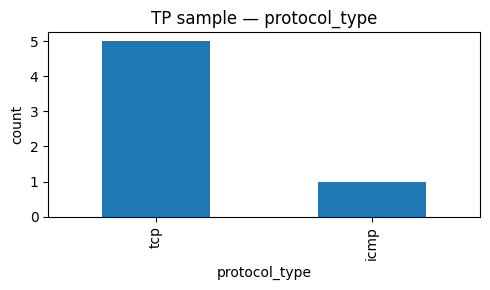

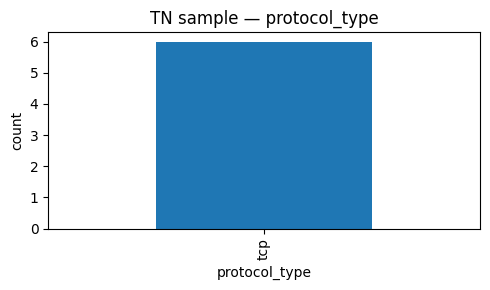

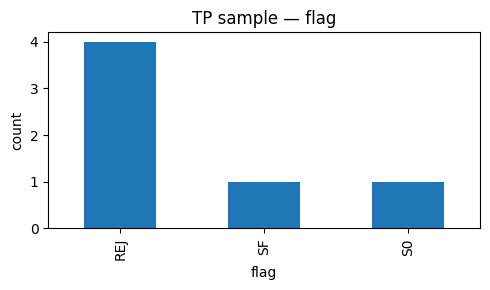

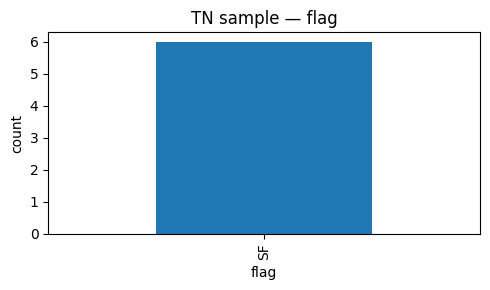

In [13]:

#@title Bar charts for TP/TN samples (protocol_type and flag)
import matplotlib.pyplot as plt

def bar_counts(df, col, title):
    counts = df[col].value_counts()
    plt.figure(figsize=(5,3))
    counts.plot(kind="bar")
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

tp = examples["TP (attack correctly detected)"]
tn = examples["TN (normal correctly detected)"]

bar_counts(tp, "protocol_type", "TP sample — protocol_type")
bar_counts(tn, "protocol_type", "TN sample — protocol_type")
bar_counts(tp, "flag", "TP sample — flag")
bar_counts(tn, "flag", "TN sample — flag")


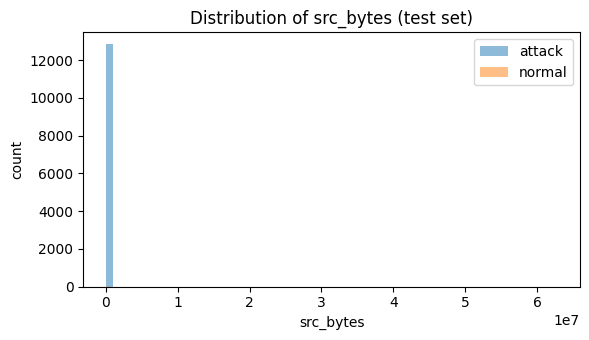

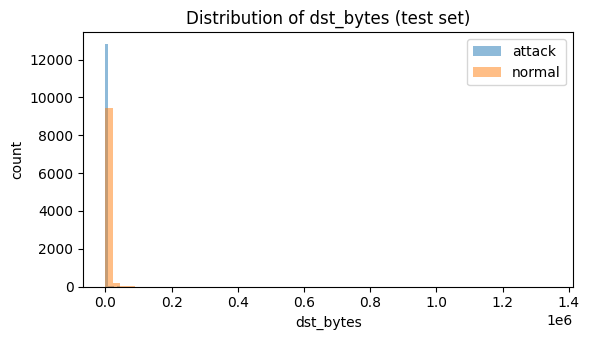

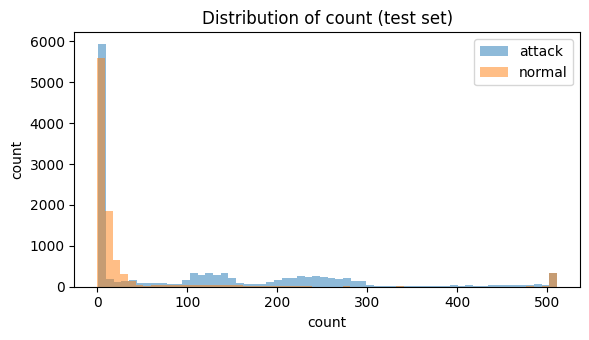

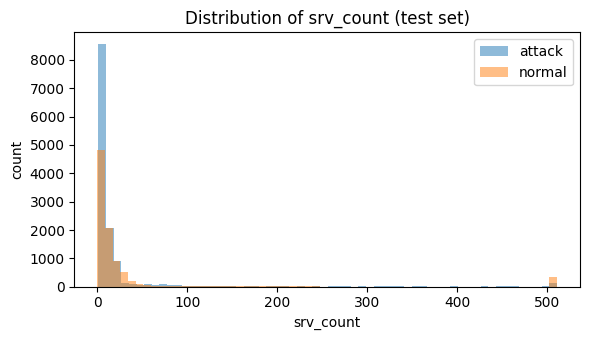

In [14]:

#@title Histograms across the test set (attack vs normal)
att_mask = (y_test == 1)
norm_mask = ~att_mask

def hist_feature(colname, bins=40):
    attack_vals = X_test.loc[att_mask, colname].values
    normal_vals = X_test.loc[norm_mask, colname].values
    plt.figure(figsize=(6,3.5))
    plt.hist(attack_vals, bins=bins, alpha=0.5, label="attack")
    plt.hist(normal_vals, bins=bins, alpha=0.5, label="normal")
    plt.title(f"Distribution of {colname} (test set)")
    plt.xlabel(colname)
    plt.ylabel("count")
    plt.legend()
    plt.tight_layout()
    plt.show()

for feat in ["src_bytes", "dst_bytes", "count", "srv_count"]:
    hist_feature(feat, bins=60)



## 🎯 One example from each bucket
Quick single-row view for screenshots in slides.


In [15]:

#@title Pretty-print one row from TP/TN/FP/FN
from IPython.display import display

def show_one(df, title):
    print("="*len(title))
    print(title)
    print("="*len(title))
    display(df.head(1))

show_one(examples["TP (attack correctly detected)"], "TP — attack correctly detected")
show_one(examples["TN (normal correctly detected)"], "TN — normal correctly detected")
show_one(examples["FP (normal flagged as attack)"], "FP — normal flagged as attack")
show_one(examples["FN (missed attack)"], "FN — missed attack")


TP — attack correctly detected


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,1,1,0.999788,0,tcp,private,REJ,0,0,0,...,255,10,0.04,0.06,0.0,0.0,0.0,0.0,1.0,1.0


TN — normal correctly detected


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,0.028818,2,tcp,ftp_data,SF,12983,0,0,...,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.0,0.0


FP — normal flagged as attack


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,0.995311,0,udp,private,SF,45,44,0,...,255,255,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


FN — missed attack


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,1,0,0.007981,1,tcp,telnet,RSTO,0,15,0,...,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71
